### 1. Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import requests
import os
import copy
from zipfile import ZipFile
from timeit import default_timer as timer
import json
from tqdm.auto import tqdm

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms as T
from torchvision.models import inception_v3, resnet50, Inception_V3_Weights, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader, random_split
from nltk.tokenize import word_tokenize
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.profiler import profile, record_function, ProfilerActivity

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
SEED = 21
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on', device)

Running on cuda


### 2. Download Dataset

In [3]:
data_dir = Path('Data')
data_dir.mkdir(parents=True, exist_ok=True)
with open(data_dir/'data.zip', 'wb') as f:
    # request = requests.get('http://images.cocodataset.org/zips/train2017.zip')
    request = requests.get('http://images.cocodataset.org/zips/val2014.zip')
    f.write(request.content)

with ZipFile(data_dir/'data.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)
    print('Data extracted to directory', str(data_dir))

In [4]:
with open(data_dir/'annotations.zip', 'wb') as f:
    request = requests.get('http://images.cocodataset.org/annotations/annotations_trainval2014.zip')
    f.write(request.content)

with ZipFile(data_dir/'annotations.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)
    print('Annotations extracted to directory', str(data_dir))

Annotations extracted to directory Data


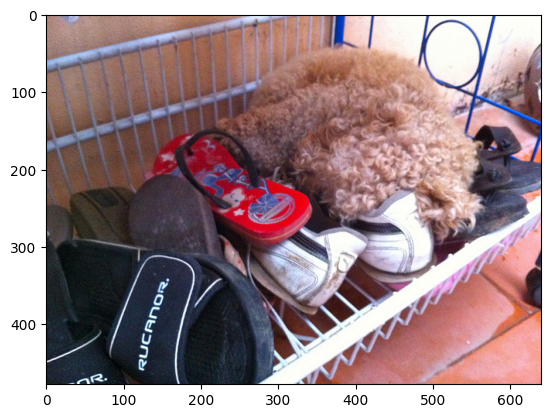

In [4]:
img_paths = sorted(list(data_dir.glob('*/*.jpg')))

test_img = Image.open(img_paths[0])
plt.imshow(test_img)

In [5]:
annot_pth = data_dir/'annotations/captions_val2014.json'
with open(annot_pth, 'r') as f:
    json_annots = json.load(f)
    # list of dictionaries containing image_id, id, and caption
    annotations = json_annots['annotations']

annot_data = []
for sample_dict in annotations:
    padded_id = "%012d.jpg" % sample_dict['image_id']
    img_path = data_dir/('val2014/COCO_val2014_' + padded_id)
    data_sample = [img_path, sample_dict['caption']]
    annot_data.append(data_sample)
annot_data = sorted(annot_data)
print(annot_data[0])

[PosixPath('Data/val2014/COCO_val2014_000000000042.jpg'), 'A dog sleeping on a show rack in the shoes.']


### 3. Preprocess Data

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s] 


ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

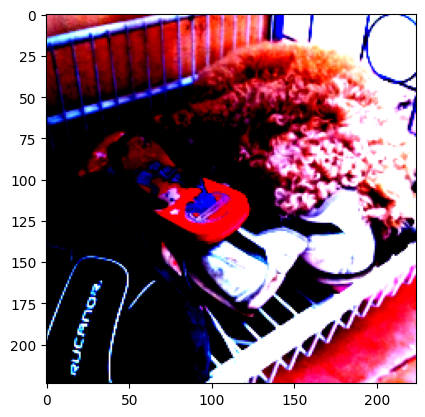

In [6]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)
# weights = Inception_V3_Weights.DEFAULT
# inception = inception_v3(weights=weights)
# inception.aux_logits = False
transform = weights.transforms()
transformed_img = transform(test_img)
plt.imshow(transformed_img.permute(1, 2, 0))
transform

PREPROCESS Captions
1. General text preprocessing - tokenize, lowercase
2. Vocabulary - word2idx dict
3. Start and end token before and after each caption
4. Index form for using embeddings

In [7]:
class COCODataset(Dataset):
    """Preprocess image and captions for the COCO dataset

    Args
        img_pths (list[pathlib.PosixPath]): list of image paths that will be fetched by idx
        annot_pth (pathlib.PosixPath): path to the json file with the image captions
        transform: torchvision transformation pipeline for preprocessing image inputs
    """
    def __init__(self, img_pths: list, annot_pth, transform):
        self.img_pths = img_pths
        self.transform = transform
        self.captions = self.get_captions(annot_pth)
        self.token_captions = [word_tokenize(caption.lower()) for caption in self.captions]
        self.start_token, self.end_token = "<start>", "<end>"
        self.word2idx = self.get_vocab(self.token_captions)

    def get_captions(self, annot_pth):
        with open(annot_pth, 'r') as f:
            json_annots = json.load(f)
            # list of dictionaries containing image_id, id, and caption
            annotations = json_annots['annotations']

        # transfer to dict - img_path, caption
        annot_data = dict()
        for sample_dict in annotations:
            padded_id = "%012d.jpg" % sample_dict['image_id']
            img_path = data_dir/('val2014/COCO_val2014_' + padded_id)
            annot_data[img_path] = sample_dict['caption']
        captions = [annot_data[key] for key in sorted(annot_data.keys())] # sort and keep only captions
        return captions

    def get_vocab(self, token_captions) -> dict[str, int]:
        word2idx = dict()
        word2idx[self.start_token] = 1
        word2idx[self.end_token] = 2
        idx = 3
        for token_caption in token_captions:
            for token in token_caption:
                if word2idx.get(token, 0) == 0:
                    word2idx[token] = idx
                    idx += 1
        return word2idx

    def __len__(self):
        return len(self.img_pths)

    def __getitem__(self, index):
        image = Image.open(self.img_pths[index])
        image = image.convert("RGB")
        if transform is not None:
            image = self.transform(image)
        
        token_caption = self.token_captions[index]
        final_captions = []
        final_captions.append(self.word2idx[self.start_token])
        final_captions.extend([self.word2idx[token] for token in token_caption])
        final_captions.append(self.word2idx[self.end_token])

        # pad with 0 up to max caption length to match dims of all captions
        pad_length = 54 - len(final_captions)
        final_captions = torch.tensor(final_captions)
        final_captions = F.pad(input=final_captions, pad=(0, pad_length), mode='constant', value=0)
        
        return image, final_captions

In [8]:
torch.manual_seed(SEED)

dataset = COCODataset(img_paths, annot_pth, transform)
train_data, val_data, test_data = random_split(dataset, [0.8, 0.1, 0.1])
len(train_data), len(val_data), len(test_data)

(32404, 4050, 4050)

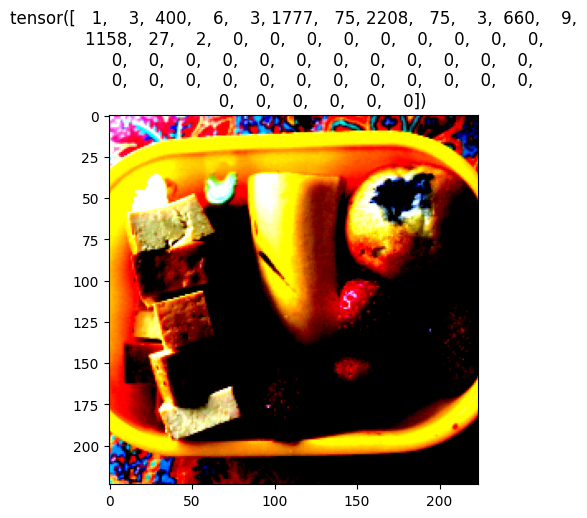

In [83]:
sample_img, sample_caption = train_data[2]
plt.imshow(sample_img.permute(1, 2, 0))
plt.title(sample_caption)
plt.show()

In [21]:
vocab = list(train_data.dataset.word2idx)
text = []
for word_idx in sample_caption:
    actual_idx = word_idx - 1
    text.append(vocab[actual_idx])
    if vocab[actual_idx] == "<end>":
        break
print(" ".join(text))
print("Vocab size:", len(dataset.word2idx))

<start> a bowl with a muffin , strawberries , a banana and chicken . <end>
Vocab size: 9715


In [9]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()
collate_fn = lambda batch: tuple(zip(*batch))

train_dl = DataLoader(dataset=train_data,
                      batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS,
                      collate_fn=collate_fn,
                      shuffle=True)

val_dl = DataLoader(dataset=val_data,
                     batch_size=BATCH_SIZE,
                     num_workers=NUM_WORKERS,
                     collate_fn=collate_fn)

test_dl = DataLoader(dataset=test_data,
                     batch_size=BATCH_SIZE,
                     num_workers=NUM_WORKERS,
                     collate_fn=collate_fn)

In [23]:
print(f"Train Dataloader: {len(train_dl)} batches of {train_dl.batch_size}")
print(f"Val Dataloader: {len(val_dl)} batches of {val_dl.batch_size}")
print(f"Test Dataloader: {len(test_dl)} batches of {test_dl.batch_size}")

Train Dataloader: 507 batches of 64
Val Dataloader: 64 batches of 64
Test Dataloader: 64 batches of 64


In [12]:
img_batch, caption_batch = next(iter(train_dl))
torch.stack(img_batch).shape, torch.stack(caption_batch).shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 54]))

### 5. Build CNN-LSTM Model

In [14]:
class Encoder(nn.Module):
    def __init__(self, encoder_model, embed_size, pretrained=True):
        super().__init__()
        self.cnn = encoder_model
        if pretrained:
            for names, param in self.cnn.named_parameters():
                if 'fc' not in names:
                    param.requires_grad = False
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, embed_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.cnn(x)

In [59]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, dropout_rate: float=0.5):
        super().__init__()
        self.embed = nn.Embedding(vocab_size+1, embed_size, padding_idx=0) # +1 for padding idx shift
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True) # input size and hidden size
        self.linear = nn.Linear(hidden_size, vocab_size+1)
        self.dropout = nn.Dropout(dropout_rate)
        # self.rnn = nn.RNN(embed_size, hidden_size, num_layers=decoder_layers,batch_first=True, nonlinearity='tanh')
        
    def forward(self, features, captions):
        embedded_captions = self.embed(captions)
        embeddings = self.dropout(embedded_captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        hiddens, (hn, cn) = self.lstm(embeddings) # all hidden states and final hidden and cell state (hn, cn)
        return self.linear(hiddens) # (batch_size, timesteps/embed_height, vocab_size+1)
    
    # Greedy search
    def inference(self, features):
        sequence_logits = []
        output = []
        input_word = features # initially img embed
        last_ht = None
        MAX_WORDS = 70
        
        for _ in range(MAX_WORDS):
            # lstm only generates one timestep each given just img or word
            hiddens, last_ht = self.lstm(input_word.unsqueeze(1), last_ht) # pass in previous hidden state
            y_logits = self.linear(hiddens)
            y_logits = y_logits.squeeze(1) # remove timestep dim
            sequence_logits.append(y_logits)
            
            word_idx = y_logits.argmax(1)
            output.append(word_idx.item())
            if word_idx==2: # <end> - idx after pad and <start>
                break

            input_word = self.embed(word_idx)

        return sequence_logits, output

    def inference_beam_search(self, features, beam_size):
        inputs = features
        MAX_WORDS = 30
        completed_sequences = []

        # Step 1: Predict first word from image embedding
        hiddens, last_ht = self.lstm(inputs.unsqueeze(1))

        # Step 2: Initialize DS for tracking sequence generated -
        # Each sequence in sequences represented as three parts:
        # 1) its start word index, 2) its cumulative probability (initially 1)
        # 3) last hidden state
        sequences = [[[torch.tensor(1)], 1.0, last_ht]] # [[[<start>], cum_prob=1, h_t-1]]

        count = 0
        while beam_size > 0 and len(sequences[0][0]) < MAX_WORDS:
            count += 1
            temp = []
            for seq in sequences:
                # Step 3: embed X_t-1 and get h_t-1
                inputs = seq[0][-1].unsqueeze(0).to(device)
                inputs = self.embed(inputs) # (1, embed_size)
                last_ht = torch.stack(seq[2]).squeeze(1) # make copy of h_t across inner loops
                if len(last_ht.shape) == 2:
                    last_ht = last_ht.unsqueeze(1)

                # Step 4: generate vocab dist predicting next word/timestep
                hiddens, last_ht = self.lstm(inputs, last_ht)
                y_logits = self.linear(hiddens).squeeze(1)

                # Step 5: Sort pred probs (desc) and extract top word probs and indices for beam
                y_preds = F.log_softmax(y_logits, dim=1)
                sorted_probs, indices = torch.sort(-y_preds, dim=1) # reverse sign for desc
                word_preds = indices[0][:beam_size]
                top_probs = sorted_probs[0][:beam_size]

                # Step 6: track each best seq branching off current seq and their cum prob
                # (append to temp)
                for i, w in enumerate(word_preds):
                    next_caption, prob = seq[0].copy(), seq[1] # ensure new list created
                    if w != 2: # prevent extending ended sequences
                        next_caption.append(w.to(device))
                        prob += top_probs[i].item()
                        temp.append([next_caption, prob, last_ht])
                    else:
                        beam_size -= 1 # beam search variation where first sequences taken
                        next_caption.append(w)
                        completed_sequences.append([next_caption, prob, last_ht])

                # e.g. if beam_size = 3
                # - iter 0 0: temp = [[[<start>, I],0.5, h_1], [[<start>, A],0.3, h_1], [[<start>, The], 0.1, h_1]]
                # - sequences = temp
                # - iter 1 0: temp = [[[<start>, I, am], 0.3, h_2], [[<start>, I, was], 0.2, h_2], [[<start>, I, will]], 0.1, h_2]
                # - iter 1 1: temp = [[[<start>, I, am], 0.3, h_2], [[<start>, I, was], 0.2, h_2], [[<start>, I, will]], [[<start>, The, first], 0.4, h_2b], [[<start>, The, person], 0.1, h_2b]...]
                # - iter 1 2 etc. len(temp) == 9
                # - sequences = sorted_temp[:beam_size]
                # - sequences = [[<start>, The, first], 0.4, h_2b], [[<start>, I, am], 0.3, h_2]
            
    
            sequences = temp
            # Sort again by prob (may be from different branches)
            ordered = sorted(sequences, key=lambda seq: seq[1])
            
            # Keep only top beams
            sequences = ordered[:beam_size]

        top_sequences = [seq[0] for seq in completed_sequences]  # Get the word indices of best sequences
        top_scores = [seq[1] for seq in completed_sequences]
        return top_sequences, top_scores

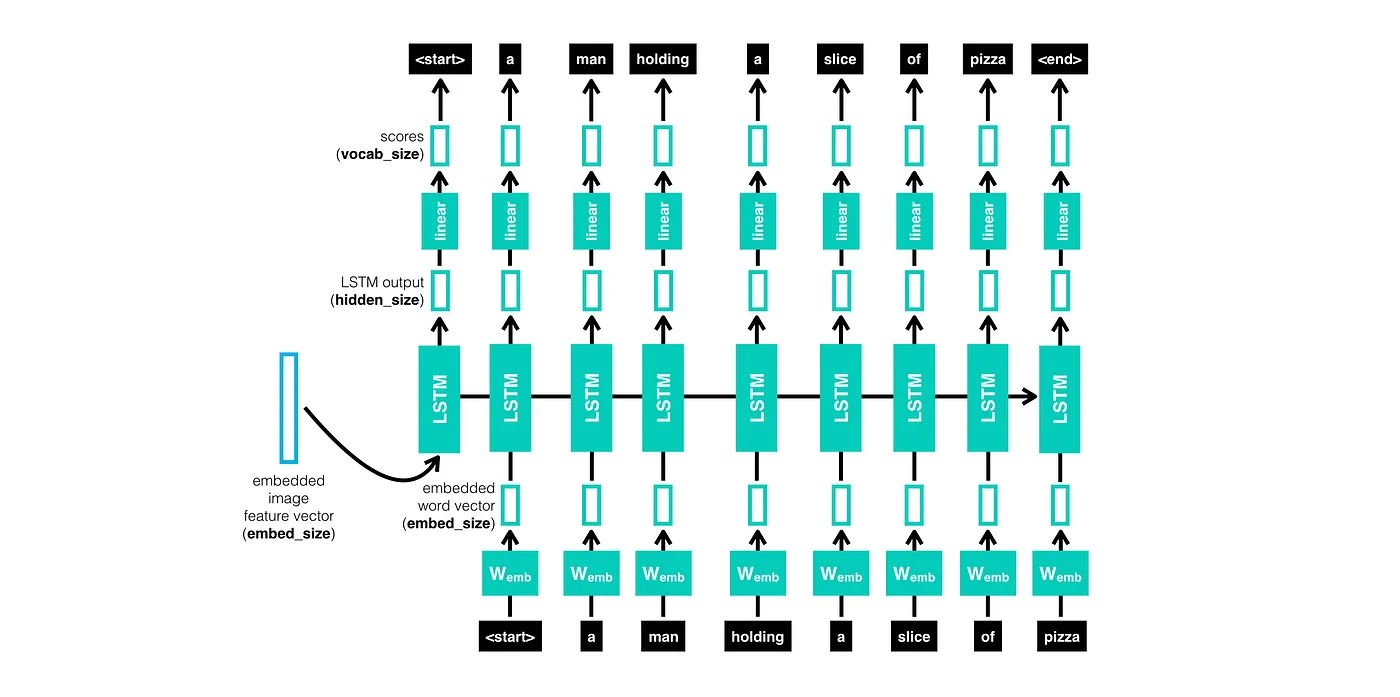
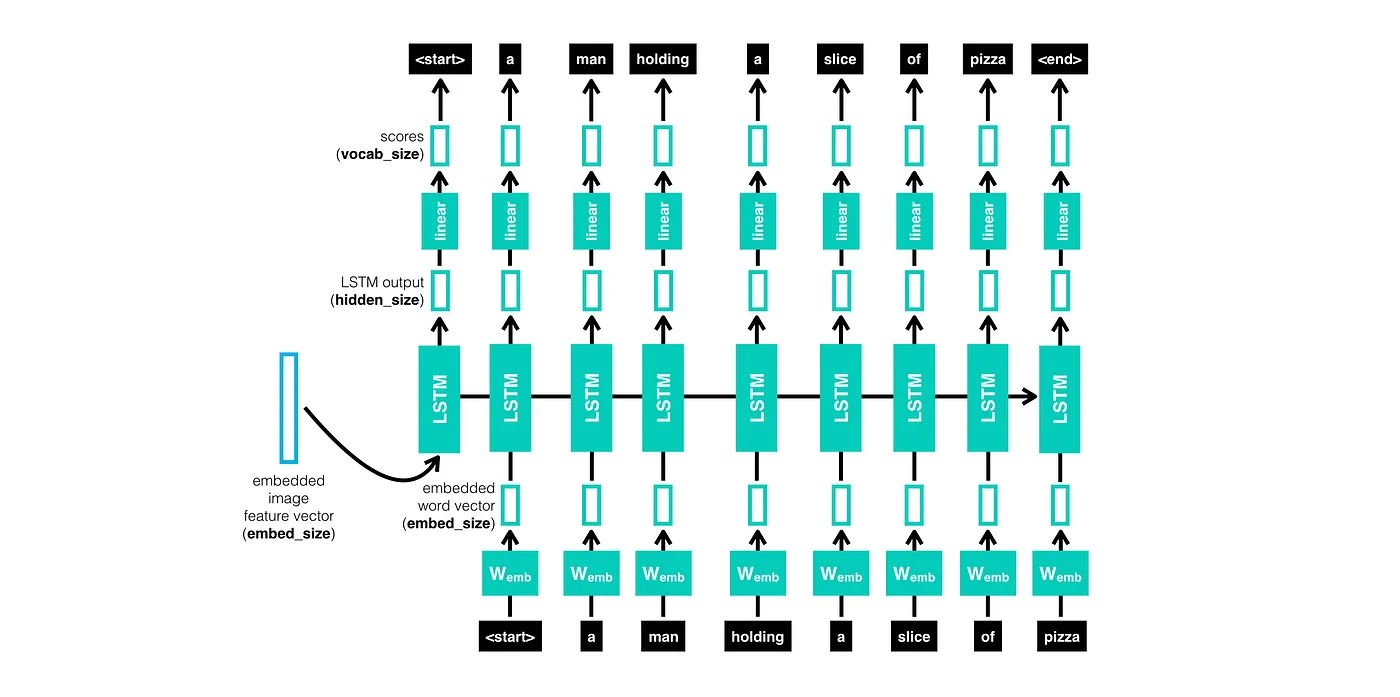

In [16]:
class ImageCaptionModel(nn.Module):
    def __init__(self, encoder_model, embed_size, hidden_size, vocab_size, pretrained_encoder=True, dropout_rate=0.5):
        super().__init__()
        self.encoder = Encoder(encoder_model, embed_size, pretrained_encoder)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, dropout_rate)

    def forward(self, images, captions=None, beam_size=None) -> torch.Tensor:
        if captions != None:
            return self.decoder(self.encoder(images), captions)
        elif beam_size != None:
            return self.decoder.inference_beam_search(self.encoder(images), beam_size)
        else:
            return self.decoder.inference(self.encoder(images))

In [60]:
torch.manual_seed(SEED)

EMBED_SIZE = 512
DROPOUT = 0.65
VOCAB_SIZE = len(dataset.word2idx)
model = ImageCaptionModel(
    encoder_model=resnet,
    embed_size=EMBED_SIZE,
    hidden_size=EMBED_SIZE,
    vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT
)

In [21]:
# Test model input
model(torch.stack(img_batch), torch.stack(caption_batch)).shape

torch.Size([64, 55, 9716])

### 6. Train model

In [18]:
def save_model(model_path, model_state_dict, results_dict):
    torch.save({
        "model": model_state_dict,
        "results": results_dict
    }, f=model_path)

def load_model(model_path, model):
    loaded_dict = torch.load(model_path)
    model.load_state_dict(loaded_dict["model"])
    return model, loaded_dict["results"]

In [33]:
def train_steps(model, train_dl, l2_lambda, loss_fn, optimizer, device):
    model.train()
    train_loss, train_perplexity = 0, 0
    for b, (b_images, b_captions) in enumerate(train_dl):
        b_images, b_captions = torch.stack(b_images), torch.stack(b_captions) # tuple to tensor
        b_images, b_captions = b_images.to(device), b_captions.to(device)
        y_logits = model(b_images, b_captions)

        dummy_pad = torch.zeros((b_captions.shape[0], 1), device=device) # account for excess timestep from image embedding (.shape for last uneven batch)
        b_captions = torch.concat((b_captions, dummy_pad), dim=1)
        b_captions = b_captions.view(-1).type(torch.long)
        loss = loss_fn(y_logits.view(-1, VOCAB_SIZE+1), b_captions) # infer/flatten dim for crossentropy shape req; outputs loss for each timestep
       
        # pad_mask = b_captions != 0
        # loss = loss[pad_mask] # apply binary mask for omitting pad idxs
        # loss = loss.mean() # manual reduction with mean

        # if l2_lambda:
        #     l2_norm = sum(w.pow(2).sum() for w in model.parameters() if w.requires_grad)
        #     loss += l2_lambda * l2_norm
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # calculate perplexity
        perplexity = torch.exp(loss)
        train_perplexity += perplexity.item()
        if (b+1) % 101 == 0:
            print(f"Examined {(b+1) * train_dl.batch_size}/{len(train_dl.dataset)} samples")

    train_loss /= len(train_dl)
    train_perplexity /= len(train_dl)
    return train_loss, train_perplexity
        

In [24]:
def val_steps(model, val_dl: torch.utils.data.DataLoader, loss_fn, device):
    val_loss, val_perplexity = 0, 0
    model.eval()
    with torch.inference_mode():
        for b_images, b_captions in val_dl:
            b_images, b_captions = torch.stack(b_images), torch.stack(b_captions)
            b_images, b_captions = b_images.to(device), b_captions.to(device)
            y_logits = model(b_images, b_captions)
            
            dummy_pad = torch.zeros((b_captions.shape[0], 1), device=device) # account for excess timestep from image embedding
            b_captions = torch.concat((b_captions, dummy_pad), dim=1)
            b_captions = b_captions.view(-1).type(torch.long)
            loss = loss_fn(y_logits.view(-1, VOCAB_SIZE+1), b_captions)
    
            # pad_mask = b_captions != 0
            # loss = loss[pad_mask].mean()
            val_loss += loss.item()
            val_perplexity += torch.exp(loss).item()
    
        val_loss /= len(val_dl)
        val_perplexity /= len(val_dl)

    return val_loss, val_perplexity

In [50]:
def train(model,
          epochs: int,
          train_dl: torch.utils.data.DataLoader,
          val_dl: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer,
          warmup_scheduler=None,
          decay_scheduler=None,
          warmup_epochs=15,
          l2_lambda: float=None,
          seed: int=None,
          device: torch.device="cpu"):
    if seed:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

    model.to(device)

    results = {'train_loss': [],
               'train_perplexity': [],
               'val_loss': [],
               'val_perplexity': []}

    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n------")
        train_loss, train_perplexity = train_steps(model, train_dl, l2_lambda, loss_fn, optimizer, device, warmup_scheduler, decay_scheduler)
        val_loss, val_perplexity = val_steps(model, val_dl, loss_fn, device)
        print(typ(epoch))
        if epoch < warmup_epochs and warmup_scheduler:
            warmup_scheduler.step()
        elif decay_scheduler:
            decay_scheduler.step()

        print(f"Train loss: {train_loss:.3f} | Train Perplexity: {train_perplexity:.3f} | Validation loss: {val_loss:.3f} | Validation Perplexity: {val_perplexity:.3f}")
        results['train_loss'].append(train_loss)
        results['train_perplexity'].append(train_perplexity)
        results['val_loss'].append(val_loss)
        results['val_perplexity'].append(val_perplexity)

        if (epoch + 1) % 5 == 0:
            save_model(f"caption_model_ep{epoch+1}.pt", model.state_dict(), results)

    return results

In [ ]:
lr = 0.001
l2_lambda = 0.005
EPOCHS = 35

loss_fn = nn.CrossEntropyLoss(ignore_index=0) 
optimizer = optim.AdamW(params=model.parameters(), lr=lr)
warmup_scheduler = StepLR(optimizer, step_size=3, gamma=1.2)
decay_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

In [87]:
# Train model
results = train(
    model=model,
    epochs=EPOCHS,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    l2_lambda=l2_lambda,
    seed=SEED,
    device=device,
    warmup_scheduler=warmup_scheduler,
    decay_scheduler=decay_scheduler
)

### 7. Evaluation and Test

In [102]:
loaded_model, results = load_model("caption_model_ep85.pt", model)
loaded_model.to(device)
test_images, test_captions = next(iter(test_dl))

<ipython-input-18-9c73df288156>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load(model_path)


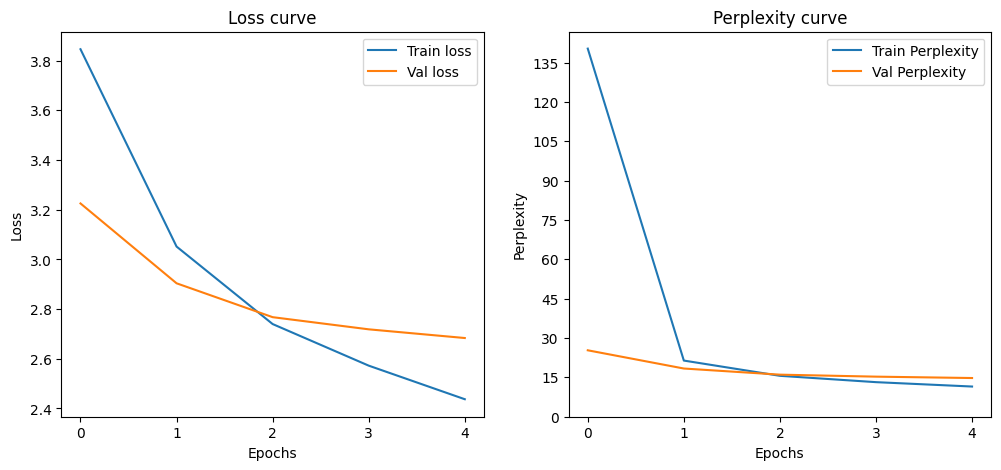

In [24]:
def plot_training(results: dict):
    epochs = len(results['train_loss'])
    x_data = list(range(epochs))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(x_data, results['train_loss'], label='Train loss')
    ax1.plot(x_data, results['val_loss'], label='Val loss')
    ax1.set_title('Loss curve')
    ax1.set_xticks(x_data)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(x_data, results['train_perplexity'], label='Train Perplexity')
    ax2.plot(x_data, results['val_perplexity'], label='Val Perplexity')
    ax2.set_title('Perplexity curve')
    ax2.set_xticks(x_data)
    ax2.set_yticks(list(range(0, 150, 15)))
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Perplexity')
    ax2.legend()
    plt.show()

plot_training(results)

In [106]:
# Evaluation
# Observation: outputs semantically correct but precision of exact phrasing and word pos vary with only image input
test_perplexity = 0
for test_img, test_caption in test_data:
    test_img, test_caption = test_img.to(device), test_caption.to(device)
    y_logits, _ = loaded_model(test_img.unsqueeze(0))
    out_tensor = torch.stack(y_logits)
    
    loss = loss_fn(out_tensor.squeeze(1), test_caption[:len(out_tensor)]) # only evaluate generated words up to end token
    test_perplexity += torch.exp(loss)

test_perplexity /= len(train_data)
print(f"Test perplexity (images only): {test_perplexity: .3f}")

Test perplexity (images only):  470.202


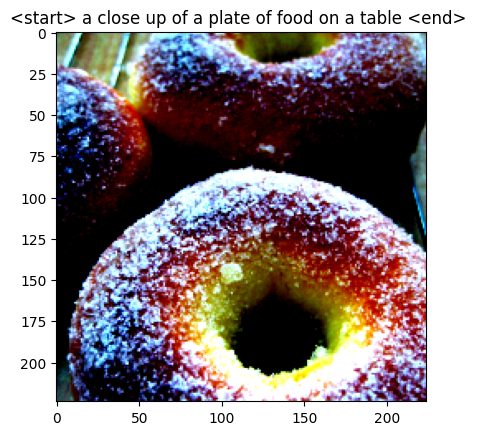

In [50]:
# Greedy search test
test_idx = 3
caption = ""
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True,
             record_shapes=True) as prof: # profile inference time and memory consumption
    loaded_model.eval()
    with torch.inference_mode():
        with record_function('model_inference'):
            _, output = loaded_model(torch.stack(test_images)[test_idx].to(device).unsqueeze(0))
        vocab = list(train_data.dataset.word2idx)
        for word_idx in output:
            caption += vocab[word_idx-1] + " "
            if word_idx == 2:
                break

plt.title(caption)
plt.imshow(torch.stack(test_images)[test_idx].permute(1, 2, 0))

In [48]:
print(prof.key_averages().table(sort_by='cuda_time_total', row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us      43.382ms       414.41%      43.382ms      14.461ms           0 b           0 b           0 b           0 

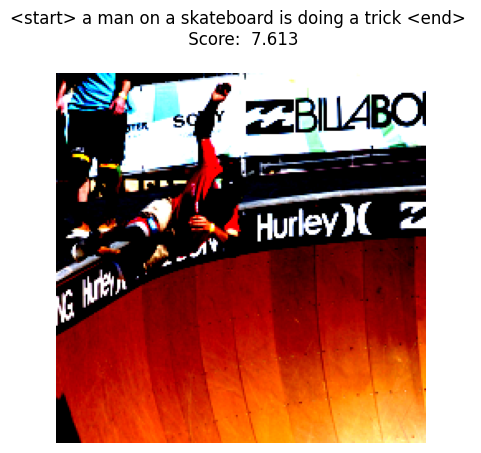

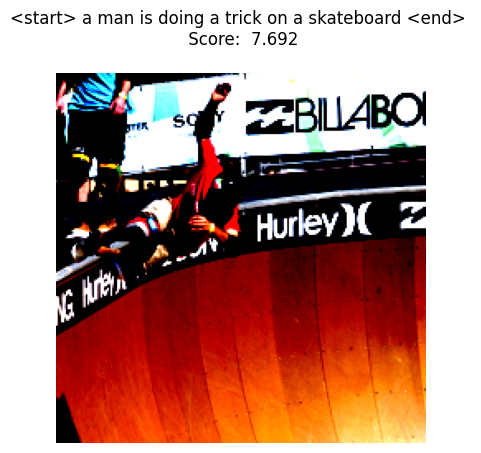

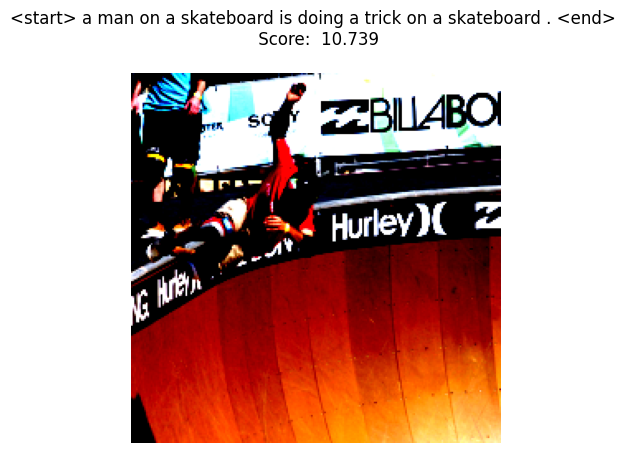

In [108]:
# Beam search test
BEAM_SIZE = 3
test_idx = 11

loaded_model.eval()
with torch.inference_mode():
    top_sequences, top_scores = loaded_model(torch.stack(test_images)[test_idx].unsqueeze(0).to(device),
                         beam_size=BEAM_SIZE)
    
    for sequence, score in zip(top_sequences, top_scores):
        vocab = list(train_data.dataset.word2idx)
        caption = ""
        for word_idx in sequence:
            caption += vocab[word_idx-1] + " "
            if word_idx == 2:
                break
        plt.title(f"{caption}\n Score: {score: .3f}\n")
        plt.imshow(torch.stack(test_images)[test_idx].permute(1, 2, 0))
        plt.axis(False)
        plt.show()

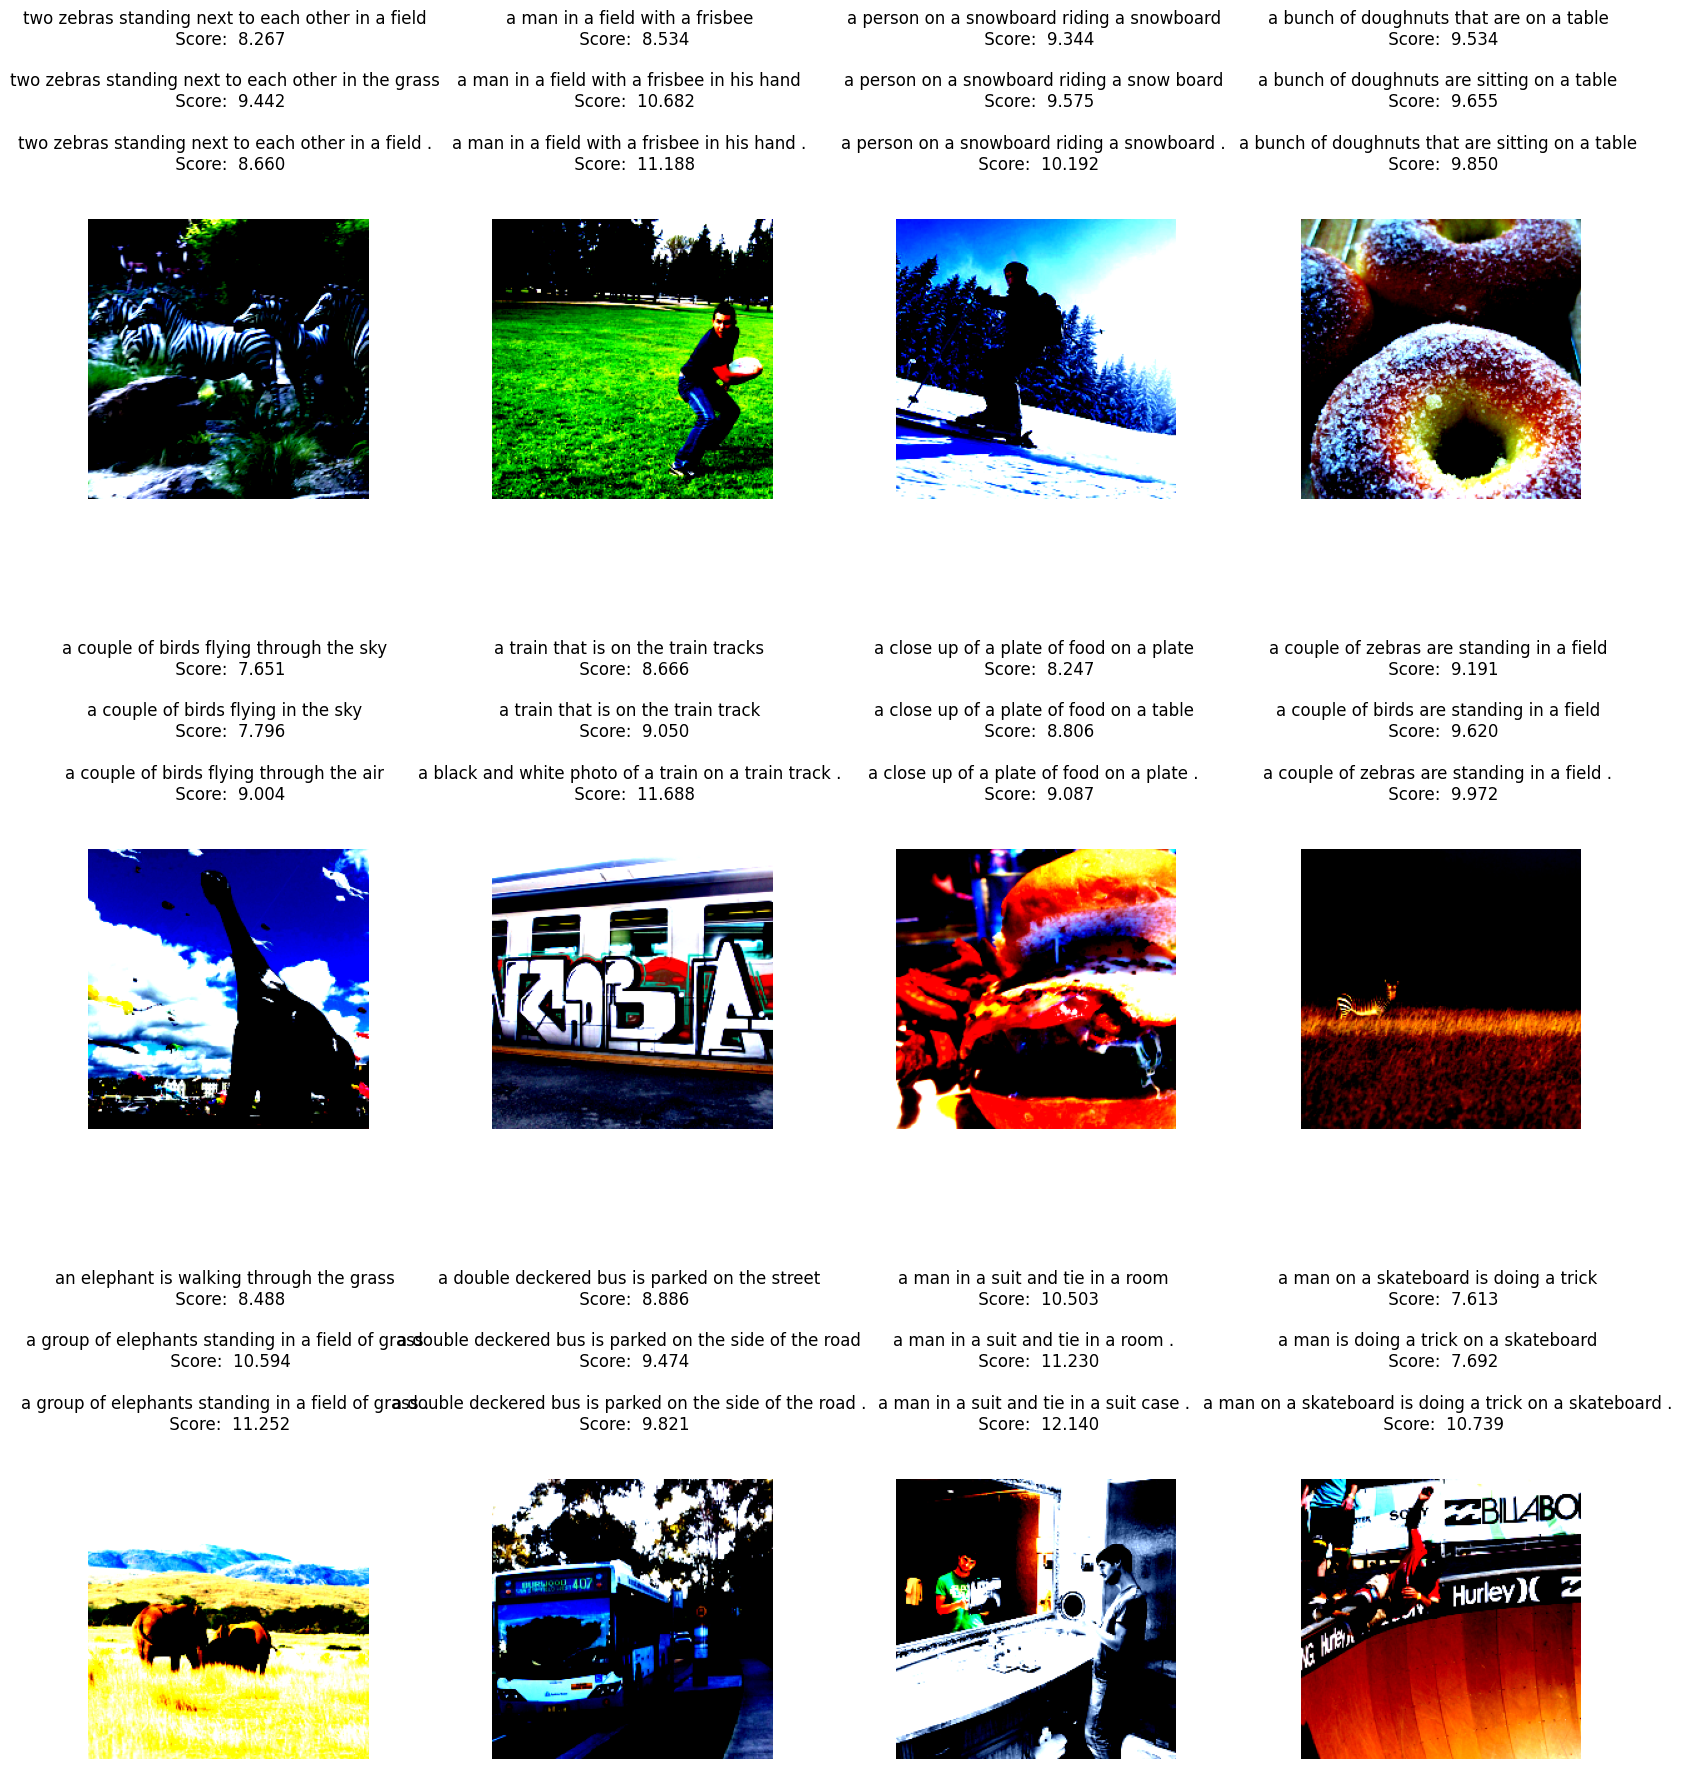

In [147]:
def plot_inferences(images, beam_size):
    vocab = list(train_data.dataset.word2idx)
    loaded_model.eval()
    with torch.inference_mode():
        fig, axs = plt.subplots(3, 4, figsize=(20, 20))
        for test_idx in range(12):
            row_num, col_num = test_idx // 4, test_idx % 4
            top_sequences, top_scores = loaded_model(torch.stack(images)[test_idx].unsqueeze(0).to(device),
                             beam_size=beam_size)
            
            disp_text = ""
            for sequence, score in zip(top_sequences, top_scores):
                caption = ""
                for word_idx in sequence[1:-1]:
                    caption += vocab[word_idx-1] + " "
                    if word_idx == 2:
                        break
                disp_text += f"{caption}\n Score: {score: .3f}\n\n"
            axs[row_num, col_num].set_title(disp_text, size=12)
            axs[row_num, col_num].imshow(torch.stack(images)[test_idx].permute(1, 2, 0))
            axs[row_num, col_num].axis(False)
        plt.subplots_adjust(hspace=1.25)
        plt.show()

plot_inferences(test_images, beam_size=3)